In [1]:
# Author : https://github.com/boguss1225
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import trange

os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Colour Template (RGB)
RED = (255, 0, 0)
DARK_GREEN = (0, 128, 0)
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
ORANGE = (230,159,0)
GREEN = (0, 255, 0)
NAVY = (0, 0, 128)
MAGENTA = (255, 0, 255)
YELLOW = (255, 255, 0)
PURPLE = (128,0,128)
MID_GREEN = (0,200,0)

2023-01-19 18:06:58.154584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 18:06:58.939785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-19 18:06:58.939849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/

In [2]:
# TO BE CONFIGURED
PATCH_SIZE_W, PATCH_SIZE_H = 128, 128
FILE_PATH = "/home/mirap/0_DATABASE/IMAS_Salmon/2_Salmon_High_Quality_CVAT/train_images/untitled-368.jpg"

NUM_CLASSES = 11
IMAGE_SIZE = (128, 128) # w, h
MODEL_SAVE_NAME = "InceptionResNetV2_11cls"
MODEL_DIR = "trained_models/IMAS_Salmon/"+MODEL_SAVE_NAME+"/" # = save_dir

class_colour = {0:RED, 1:DARK_GREEN, 2:BLUE, 3:CYAN, 4:ORANGE, 5:GREEN, 6:NAVY, 7:MAGENTA, 8:YELLOW, 9:PURPLE, 10:MID_GREEN}

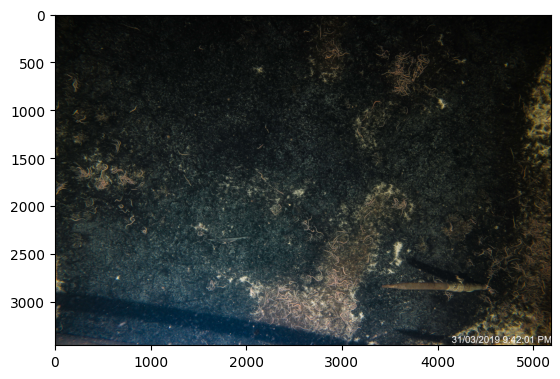

In [3]:
# Check image
img = mpimg.imread(FILE_PATH)
imgplot = plt.imshow(img)
plt.show()

In [4]:
"""
## Load model from h5
"""
model = tf.keras.models.load_model(MODEL_DIR+MODEL_SAVE_NAME+".h5")
print("load model successful")
# keras.utils.plot_model(model, show_shapes=True)

2023-01-19 18:07:02.300693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 18:07:02.789412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43215 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


load model successful


In [5]:
from utils.evaluate import eval_model
eval_model(model)

Found 1191 images belonging to 11 classes.
Found 327 images belonging to 11 classes.
Found 189 images belonging to 11 classes.


2023-01-19 18:07:12.731869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


 7/11 [==================>...........] - ETA: 0s - loss: 0.2675 - accuracy: 0.9286 - auc: 0.9883 - precision: 0.9286 - recall: 0.9286

2023-01-19 18:07:13.683266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 5s 30ms/step - loss: 0.1995 - accuracy: 0.9489 - auc: 0.9926 - precision: 0.9489 - recall: 0.9489
result of  trained_models/IMAS_Salmon/DenseNet121_11cls_v2/
The accuracy on test set is: 94.886%
The auc on test set is: 99.262%
The precision on test set is: 94.886%
The recall on test set is: 94.886%
12/12 [==============================] - 3s 54ms/step
[ lables_array ] 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[ predictio

In [6]:
# Load image
im = cv2.imread(FILE_PATH)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
img_h, img_w, img_c = im.shape
print('width:  ', img_w)
print('height: ', img_h)
print('channel:', img_c)

width:   5184
height:  3456
channel: 3


In [7]:
# Initialize blank mask image of same dimensions for drawing the shapes
bg = np.zeros_like(im, np.uint8)

In [8]:
w_ratio = int(img_w/PATCH_SIZE_W)
h_ratio = int(img_h/PATCH_SIZE_H)

In [9]:
def test_single_image(im, model):
    im = cv2.resize(im, IMAGE_SIZE)
    img_tensor = tf.convert_to_tensor(im, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor , 0)
    # img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(img_tensor)
    
    classification = np.argmax(prob)

    return classification, prob

In [10]:
# iterate image upon patch size
for h in trange(h_ratio) :
    y_min = h * PATCH_SIZE_H
    y_max = y_min + PATCH_SIZE_H
    
    for w in range(w_ratio) : 
        x_min = w * PATCH_SIZE_W
        x_max = x_min + PATCH_SIZE_W
        
        # Cropping image
        cropped_image = im[y_min:y_max,x_min:x_max]
        
        # Classify cropped image
        classfication_result, prob = test_single_image(cropped_image, model)
        
        # overlay colour on image 
        cv2.rectangle(bg, (x_min, y_min), (x_max, y_max), class_colour[classfication_result] ,cv2.FILLED)

100%|████████████████████████████████████████████████████████| 27/27 [04:03<00:00,  9.02s/it]


In [11]:
# Generate output by blending image with bg image, using the bg
# images also as mask to limit the blending to those parts
out = im.copy()
alpha = 0.5 # transparant (highest : 1.0, lowest : 0)
mask = bg.astype(bool)
out[mask] = cv2.addWeighted(im, alpha, bg, 1 - alpha, 0)[mask]

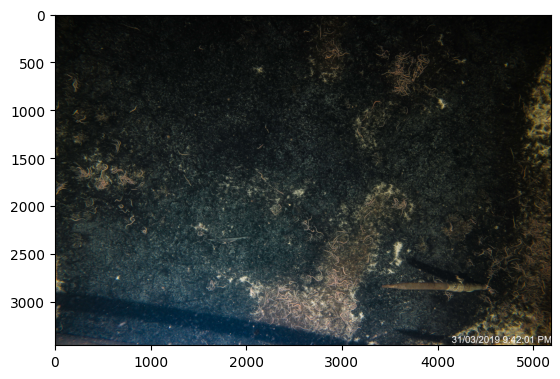

In [12]:
plt.imshow(im)

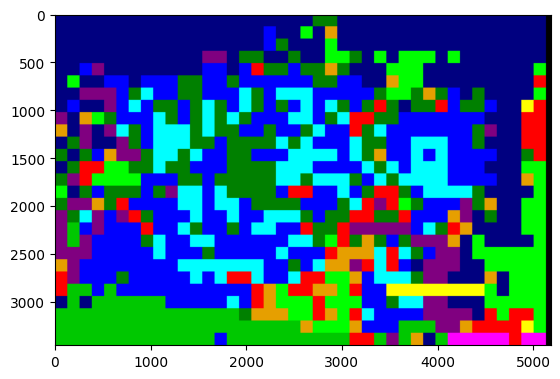

In [13]:
plt.imshow(bg)

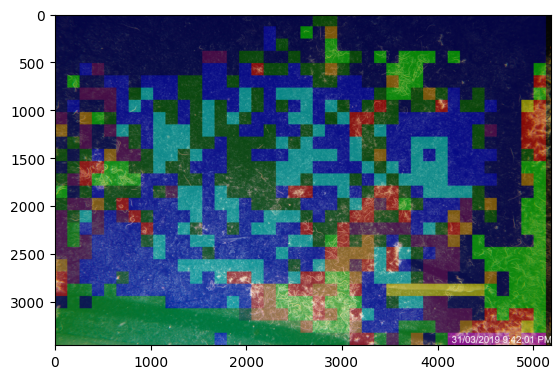

In [15]:
plt.imshow(out)
# plt.savefig(MODEL_SAVE_NAME+"_11cls")

In [16]:
def test_single_image_final(im, model):
    im = cv2.resize(im, IMAGE_SIZE)
    img_tensor = tf.convert_to_tensor(im, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor , 0)
    # img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(img_tensor)
    
    classification = np.argmax(prob)

    # class 1 : Beggiatoa-thick mat
    if classification == 0 :
        classification = 1
    # class 2 : Beggiatoa-patchy
    elif classification == 1 :
        classification = 2
    # class 3 : Beggiatoa-thin
    elif classification == 2 or classification == 3 :
        classification = 3
    # class 4 : Worm-thin
    elif classification == 4 :
        classification = 4
    # class 5 : Worm-thick
    elif classification == 5 :
        classification = 5
    # class 6 :back ground
    elif classification == 6 or classification == 7 or classification == 8 or classification == 9 or classification == 10 :
        classification = 6

#    if not sure go to background' implementation
    precision_threshold = 0.5
    if np.max(prob) < precision_threshold :
        classification = 6

    return classification

In [17]:
class_colour = {1:GREEN, 2:DARK_GREEN, 3:MID_GREEN, 4:ORANGE, 5:MAGENTA, 6:NAVY}

In [18]:
'''
reassign class into final destination class
'''
# iterate image upon patch size
for h in trange(h_ratio) :
    y_min = h * PATCH_SIZE_H
    y_max = y_min + PATCH_SIZE_H
    
    for w in range(w_ratio) : 
        x_min = w * PATCH_SIZE_W
        x_max = x_min + PATCH_SIZE_W
        
        # Cropping image
        cropped_image = im[y_min:y_max,x_min:x_max]
        
        # Classify cropped image
        classfication_result = test_single_image_final(cropped_image, model)
        
        # overlay colour on image 
        cv2.rectangle(bg, (x_min, y_min), (x_max, y_max), class_colour[classfication_result] ,cv2.FILLED)

100%|████████████████████████████████████████████████████████| 27/27 [04:03<00:00,  9.00s/it]


In [19]:
# Generate output by blending image with bg image, using the bg
# images also as mask to limit the blending to those parts
out = im.copy()
alpha = 0.5 # transparant (highest : 1.0, lowest : 0)
mask = bg.astype(bool)
out[mask] = cv2.addWeighted(im, alpha, bg, 1 - alpha, 0)[mask]

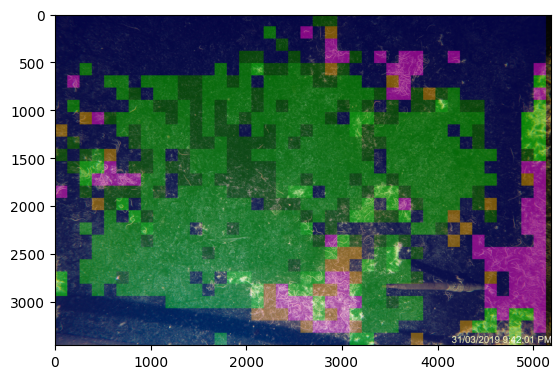

In [20]:
plt.imshow(out)

In [ ]:
# plt.savefig(MODEL_SAVE_NAME+"_cls6")